<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration04/dcgan_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 및 모듈 임포트
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [ ]:
# 데이터셋 로드
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _), (test_x, _) = fashion_mnist.load_data()
print(train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

(60000, 28, 28)
max pixel: 255
min pixel: 0


In [ ]:
# 정규화
train_x = (train_x / 255.0) * 2 -1
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
# 흑백 채널 추가
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

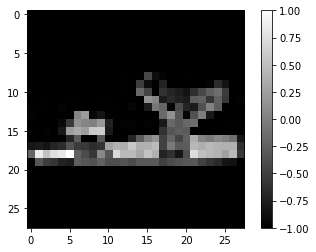

In [ ]:
# 첫 번째 데이터 확인
plt.imshow(train_x[59999].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

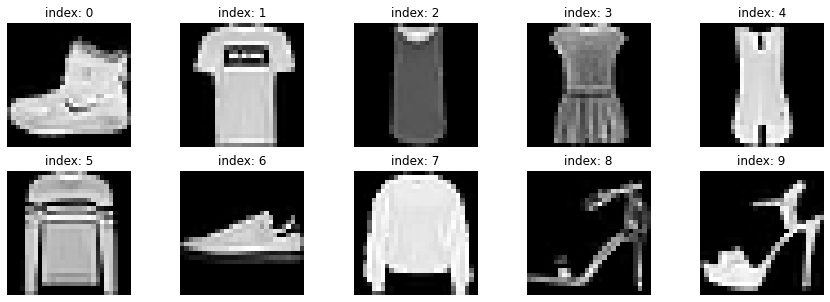

In [ ]:
# 10개 데이터 확인
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

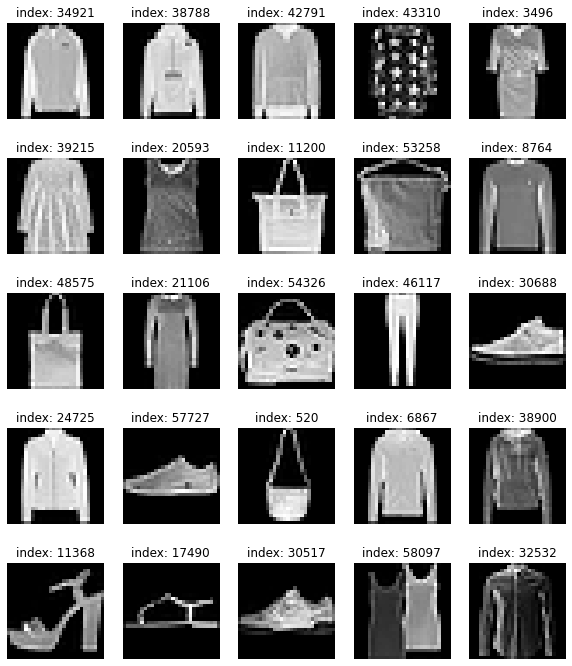

In [ ]:
# 랜덤하게 25개 데이터 확인
rand_idx = np.random.randint(0, 59999, 25)
plt.figure(figsize=(10, 12))

for i, idx in enumerate(rand_idx):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[idx].reshape(28, 28), cmap='gray')
    plt.title(f'index: {idx}')
    plt.axis('off')
plt.show()

In [ ]:
# 버퍼 및 배치 크기 설정
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# GAN generator model 함수
def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((7, 7, 256)))
	assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.
	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	assert model.output_shape == (None, 7, 7, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fourth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 14, 14, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
	assert model.output_shape == (None, 28, 28, 1)
	return model

In [ ]:
# 생성 모델을 generator라는 변수로 생성, summary 출력
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [ ]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [ ]:
# 지금은 학습하는 중이 아니니 training=False로 설정
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

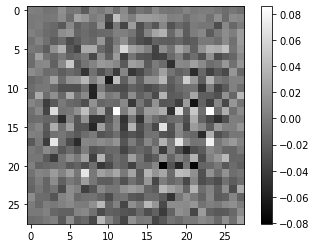

In [ ]:
# generated_image 출력
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# GAN discriminator model 함수
def make_discriminator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Conv2D Layer
	# 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
	model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Second: Conv2D Layer
	# 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Third: Flatten Layer
	model.add(layers.Flatten())

	# Fourth: Dense Layer
	# 이미지가 실제인지 (1에 가까운 값) 아니면 가짜인지 (0에 가까운 값)를 판별
	model.add(layers.Dense(1))

	return model

In [ ]:
# 판별 모델을 discriminator라는 변수로 생성, summary 출력
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [ ]:
# 가짜 이미지를 판별자에 입력시킨 결과 출력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00162327]], dtype=float32)>

In [ ]:
# 손실함수 설정
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 생성자 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 판별자 손실함수
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss =  cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# 판별자 정확도 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
# 최적화 함수(optimizer) 지정
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 생성할 샘플은 매번 같은 노이즈로 생성, 고정된 seed 노이즈
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
#  train_step,  미니배치 학습 함수
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산, 손실과 가중치, 편향을 가지고 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
# 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수, seed 이용, 고정된 seed 결과물 확인
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
# 학습 과정을 체크하기 위해 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
# checkpoint 모델
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# 전제 모델 학습 과정을 함수로 정의
# 한 단계를 학습하는 train_step
# 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images()
# 학습 과정을 시각화하는 draw_train_history()
# 모델까지 저장하기 위한 checkpoint
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# checkpoint를 위한 save_every 값 및 에포크 지정
save_every = 100
epochs = 1000

In [ ]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

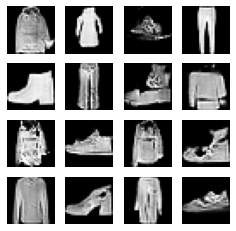

Time for training : 27384 sec


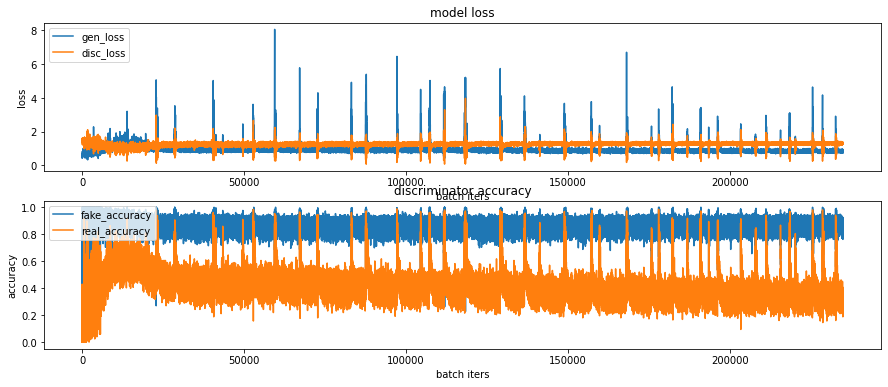

In [ ]:
# 학습 함수를 사용해서 모델 학습
# %%time
train(train_dataset, epochs, save_every)

In [ ]:
# 학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 3965153 Sep 21 19:31 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
